In [168]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from livelossplot import PlotLossesKeras
np.random.seed(7)
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM
from keras.layers.embeddings import Embedding
from keras.utils import np_utils
from keras.preprocessing import sequence
from gensim.models import Word2Vec, KeyedVectors, word2vec
import gensim
from gensim.utils import simple_preprocess
from keras.utils import to_categorical
import pickle
import h5py
from time import time
%config Completer.use_jedi = False

In [3]:
data = pd.read_csv('full_dataset_no_http.csv', index_col=0)
data = data.drop(['author','in_reply_to'], axis = 1)
print("shape:", data.shape)
print("\n")
print("sentiment values: \n", data.sentiment.value_counts())
print("\n")
print('percent of negative: ', (data.sentiment.value_counts()[-1]/data.shape[0]).round(2), '%')
print('percent of positive: ', (data.sentiment.value_counts()[1]/data.shape[0]).round(2), '%')
print('percent of neutral: ', (data.sentiment.value_counts()[0]/data.shape[0]).round(2), '%')

shape: (6504, 2)


sentiment values: 
 -1    4668
 0     977
 1     859
Name: sentiment, dtype: int64


percent of negative:  0.72 %
percent of positive:  0.13 %
percent of neutral:  0.15 %


In [11]:
def data_splitter(data):
    X = data['text']
    y = data['sentiment']

    X_train, X_val, y_train, y_bal = train_test_split(X, y, test_size=0.2, random_state=42)

    X =[]
    y = []
    return(X_train, y_train, X_val, y_val)

## Different word2vec

In [53]:
data.head()

,text,sentiment
0,W 1992r szef PSL brał udział w obaleniu rzadu ...,1
1,Wladku pamiętamy twoja pomoc. Nam się to po n...,1
2,Panie Władeczku. To jakie były ustalenia ws. o...,-1
3,Ty zielona szmxxx!,-1
4,Nigdy nie ma zadowolenia w waszej partii sami ...,-1


In [58]:
def load_word2vec(model_name):
    word2vec_model = gensim.models.word2vec.KeyedVectors.load_word2vec_format(model_name, binary=False)
    word2vec_model.fill_norms()
    word2vec_model.get_normed_vectors()
    embedding_matrix = word2vec_model.get_normed_vectors()
    return(embedding_matrix)



def data_splitter(data, top_words, mxlen, nb_classes):
    X = data['text']
    y = data['sentiment']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    
    tokenizer = Tokenizer(num_words=top_words)
    tokenizer.fit_on_texts(X)
    sequences_train = tokenizer.texts_to_sequences(X_train)
    sequences_test = tokenizer.texts_to_sequences(X_test)
    sequences_val = tokenizer.texts_to_sequences(X_val)

    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))
    print(word_index)

    X_train = sequence.pad_sequences(sequences_train, maxlen=mxlen)
    X_test = sequence.pad_sequences(sequences_test, maxlen=mxlen)
    X_val = sequence.pad_sequences(sequences_val, maxlen=mxlen)

    #y_train = np_utils.to_categorical(y_train, nb_classes)
    #y_test = np_utils.to_categorical(y_test, nb_classes)
    #y_val = np_utils.to_categorical(y_val, nb_classes)
    
    return(X_train, y_train, X_val, y_val, X_test, y_test)

In [7]:
embedding_matrix = load_word2vec('E:/Home/PythonProjects/twitter/scrapped_data/models/nkjp+wiki-lemmas-restricted-100-skipg-hs.txt.gz')

In [31]:
print('Shape of embedding matrix: ', embedding_matrix.shape)
top_words = embedding_matrix.shape[0]
mxlen = 50
nb_classes = 2

Shape of embedding matrix:  (2123132, 300)


In [59]:
(X_train, y_train, X_val, y_val, X_test, y_test) = data_splitter(data, top_words, mxlen, nb_classes)

Found 23160 unique tokens.
{'nie': 1, 'to': 2, 'i': 3, 'w': 4, 'na': 5, 'się': 6, 'z': 7, 'a': 8, 'jak': 9, 'do': 10, 'jest': 11, 'że': 12, 'pan': 13, 'co': 14, 'o': 15, 'za': 16, 'tak': 17, 'po': 18, 'ale': 19, 'czy': 20, 'tylko': 21, 'ty': 22, 'już': 23, 'bo': 24, 'dla': 25, 'od': 26, 'ma': 27, 'tym': 28, 'panie': 29, 'pis': 30, 'może': 31, 'tego': 32, 'ze': 33, 'będzie': 34, 'jeszcze': 35, 'pana': 36, 'też': 37, 'ten': 38, 'są': 39, 'tam': 40, 'jesteś': 41, 'by': 42, 'te': 43, 'gdzie': 44, 'nic': 45, 'teraz': 46, 'no': 47, 'ci': 48, 'sobie': 49, 'ja': 50, 'przez': 51, 'było': 52, 'być': 53, 'nawet': 54, 'kto': 55, 'trzeba': 56, 'wy': 57, 'polski': 58, 'coś': 59, 'sie': 60, 'dzieci': 61, 'pani': 62, 'żeby': 63, 'takie': 64, 'was': 65, 'lat': 66, 'chyba': 67, 'bez': 68, 'ich': 69, 'ludzi': 70, 'proszę': 71, 'kiedy': 72, 'można': 73, 'pod': 74, 'tej': 75, 'tych': 76, 'był': 77, 'mam': 78, 'u': 79, 'dlaczego': 80, 'przecież': 81, 'polaków': 82, 'mi': 83, 'bardzo': 84, 'ta': 85, 'masz': 

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

## Simple classifiers 100 w2v

In [52]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train,y_train)
y_pred_dtc = dtc.predict(X_test)
print("Decision Tree Classifier accuracy:", metrics.accuracy_score(y_test, y_pred_dtc))

clf = RandomForestClassifier()
clf.fit(X_train,y_train)
y_pred_clf = clf.predict(X_test)
print("Random Forest Classifier accuracy:", metrics.accuracy_score(y_test, y_pred_clf))

knc = KNeighborsClassifier(n_neighbors = 15)
knc.fit(X_train,y_train)
y_pred_knc = knc.predict(X_test)
print("K Neighbors Classifier accuracy:", metrics.accuracy_score(y_test, y_pred_knc))

Decision Tree Classifier accuracy: 0.5772482705611068
Random Forest Classifier accuracy: 0.7025365103766333
K Neighbors Classifier accuracy: 0.6641045349730976


In [5]:
embedding_matrix = load_word2vec('E:/Home/PythonProjects/twitter/scrapped_data/models/nkjp+wiki-lemmas-restricted-300-cbow-hs.txt.gz')
print('Shape of embedding matrix: ', embedding_matrix.shape)
top_words = embedding_matrix.shape[0]
mxlen = 50
nb_classes = 3

KeyboardInterrupt: 

In [54]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train,y_train)
y_pred_dtc = dtc.predict(X_test)
print("Decision Tree Classifier accuracy:", metrics.accuracy_score(y_test, y_pred_dtc))

clf = RandomForestClassifier()
clf.fit(X_train,y_train)
y_pred_clf = clf.predict(X_test)
print("Random Forest Classifier accuracy:", metrics.accuracy_score(y_test, y_pred_clf))

knc = KNeighborsClassifier(n_neighbors = 15)
knc.fit(X_train,y_train)
y_pred_knc = knc.predict(X_test)
print("K Neighbors Classifier accuracy:", metrics.accuracy_score(y_test, y_pred_knc))

Decision Tree Classifier accuracy: 0.5787855495772483
Random Forest Classifier accuracy: 0.6986933128362798
K Neighbors Classifier accuracy: 0.6641045349730976


In [55]:
embedding_matrix = load_word2vec('E:/Home/PythonProjects/twitter/scrapped_data/models/nkjp+wiki-forms-all-300-cbow-hs.txt.gz')
print('Shape of embedding matrix: ', embedding_matrix.shape)
top_words = embedding_matrix.shape[0]
mxlen = 50
nb_classes = 3

Shape of embedding matrix:  (2123132, 300)


In [56]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train,y_train)
y_pred_dtc = dtc.predict(X_test)
print("Decision Tree Classifier accuracy:", metrics.accuracy_score(y_test, y_pred_dtc))

clf = RandomForestClassifier()
clf.fit(X_train,y_train)
y_pred_clf = clf.predict(X_test)
print("Random Forest Classifier accuracy:", metrics.accuracy_score(y_test, y_pred_clf))

knc = KNeighborsClassifier(n_neighbors = 15)
knc.fit(X_train,y_train)
y_pred_knc = knc.predict(X_test)
print("K Neighbors Classifier accuracy:", metrics.accuracy_score(y_test, y_pred_knc))

Decision Tree Classifier accuracy: 0.5710991544965411
Random Forest Classifier accuracy: 0.703305149884704
K Neighbors Classifier accuracy: 0.6641045349730976


In [6]:
embedding_matrix = load_word2vec('E:/Home/PythonProjects/twitter/scrapped_data/models/nkjp+wiki-forms-all-300-cbow-ns.txt.gz')
print('Shape of embedding matrix: ', embedding_matrix.shape)
top_words = embedding_matrix.shape[0]
mxlen = 50
nb_classes = 3

Shape of embedding matrix:  (2123132, 300)


In [58]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train,y_train)
y_pred_dtc = dtc.predict(X_test)
print("Decision Tree Classifier accuracy:", metrics.accuracy_score(y_test, y_pred_dtc))

clf = RandomForestClassifier()
clf.fit(X_train,y_train)
y_pred_clf = clf.predict(X_test)
print("Random Forest Classifier accuracy:", metrics.accuracy_score(y_test, y_pred_clf))

knc = KNeighborsClassifier(n_neighbors = 15)
knc.fit(X_train,y_train)
y_pred_knc = knc.predict(X_test)
print("K Neighbors Classifier accuracy:", metrics.accuracy_score(y_test, y_pred_knc))

Decision Tree Classifier accuracy: 0.5810914681014604
Random Forest Classifier accuracy: 0.703305149884704
K Neighbors Classifier accuracy: 0.6641045349730976


## Neural Networks

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

In [22]:
stop_early = EarlyStopping(patience = 5)

In [17]:
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

In [37]:
model1 = Sequential()
model1.add(layers.Embedding(top_words, 20)) #The embedding layer
model1.add(layers.LSTM(15,dropout=0.5)) #Our LSTM layer
model1.add(layers.Dense(3,activation='softmax'))

model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=30,validation_data=(X_test, y_test),callbacks=[checkpoint1])

Epoch 1/30
 16/131 [==>...........................] - ETA: 24s - loss: 1.0632 - accuracy: 0.6274

KeyboardInterrupt: 

In [33]:
score = model1.evaluate(X_val, y_val)
print("Test Loss: %.2f%%" % (score[0]*100))
print("Test Accuracy: %.2f%%" % (score[1]*100))

33/33 [==============================] - 0s 4ms/step - loss: 1.5638 - accuracy: 0.5956
Test Loss: 156.38%
Test Accuracy: 59.56%


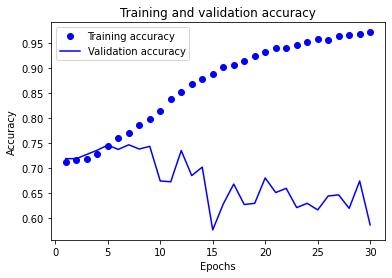

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1,31)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [18]:
model2 = Sequential()
model2.add(layers.Embedding(top_words, 40, input_length=mxlen))
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model2.add(layers.Dense(3,activation='softmax'))
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model2.fit(X_train, y_train, epochs=30,validation_data=(X_test, y_test),callbacks=[checkpoint2])

Epoch 1/30
131/131 [==============================] - 55s 385ms/step - loss: 0.8411 - accuracy: 0.7059 - val_loss: 0.7777 - val_accuracy: 0.7187

Epoch 00001: val_accuracy improved from -inf to 0.71868, saving model to best_model2.hdf5
Epoch 2/30
131/131 [==============================] - 52s 394ms/step - loss: 0.7706 - accuracy: 0.7109 - val_loss: 0.7641 - val_accuracy: 0.7187

Epoch 00002: val_accuracy did not improve from 0.71868
Epoch 3/30
131/131 [==============================] - 51s 389ms/step - loss: 0.7311 - accuracy: 0.7133 - val_loss: 0.7315 - val_accuracy: 0.7210

Epoch 00003: val_accuracy improved from 0.71868 to 0.72098, saving model to best_model2.hdf5
Epoch 4/30
131/131 [==============================] - 51s 386ms/step - loss: 0.6693 - accuracy: 0.7206 - val_loss: 0.7255 - val_accuracy: 0.7417

Epoch 00004: val_accuracy improved from 0.72098 to 0.74174, saving model to best_model2.hdf5
Epoch 5/30
131/131 [==============================] - 53s 404ms/step - loss: 0.6284 -

In [19]:
score = model2.evaluate(X_val, y_val)
print("Test Loss: %.2f%%" % (score[0]*100))
print("Test Accuracy: %.2f%%" % (score[1]*100))

33/33 [==============================] - 0s 6ms/step - loss: 1.4574 - accuracy: 0.6129
Test Loss: 145.74%
Test Accuracy: 61.29%


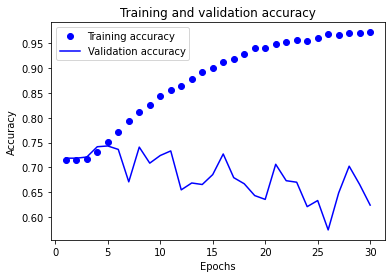

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1,31)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [22]:
model3 = Sequential()
model3.add(layers.Embedding(top_words, 40, input_length=mxlen))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.MaxPooling1D(5))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.GlobalMaxPooling1D())
model3.add(layers.Dense(3,activation='softmax'))
model3.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])
history = model3.fit(X_train, y_train, epochs=30,validation_data=(X_test, y_test))

Epoch 1/30
131/131 [==============================] - 55s 412ms/step - loss: 1.5417 - acc: 0.7040 - val_loss: 0.9173 - val_acc: 0.7187
Epoch 2/30
131/131 [==============================] - 52s 397ms/step - loss: 0.8821 - acc: 0.7219 - val_loss: 0.8477 - val_acc: 0.7187
Epoch 3/30
131/131 [==============================] - 51s 390ms/step - loss: 0.8452 - acc: 0.7170 - val_loss: 0.8329 - val_acc: 0.7187
Epoch 4/30
131/131 [==============================] - 50s 385ms/step - loss: 0.8281 - acc: 0.7167 - val_loss: 0.8259 - val_acc: 0.7187
Epoch 5/30
131/131 [==============================] - 50s 383ms/step - loss: 0.8222 - acc: 0.7157 - val_loss: 0.8191 - val_acc: 0.7187
Epoch 6/30
131/131 [==============================] - 50s 384ms/step - loss: 0.8192 - acc: 0.7139 - val_loss: 0.8107 - val_acc: 0.7187
Epoch 7/30
131/131 [==============================] - 51s 388ms/step - loss: 0.8048 - acc: 0.7199 - val_loss: 0.8025 - val_acc: 0.7187
Epoch 8/30
131/131 [==============================] - 5

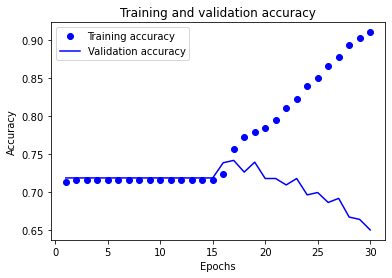

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1,31)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

##### Problems with overfitting, to counter that let's use dropouts
### First, compare first model to it's variation

In [112]:
from keras.layers import MaxPool2D, ZeroPadding2D, MaxPooling2D
from keras.layers import Dropout, BatchNormalization

In [155]:
embedding_dim = 40

model4 = Sequential()
model4.add(layers.Embedding(top_words, embedding_dim, input_length=mxlen))
model4.add(layers.Conv1D(128, 5, activation='relu'))
model4.add(layers.GlobalMaxPooling1D())
model4.add(layers.Dense(32, activation='relu'))
model4.add(layers.Dropout(0.5))
model4.add(layers.Dense(3, activation='sigmoid'))
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint4 = ModelCheckpoint("best_model4.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model4.fit(X_train, y_train, epochs=10,validation_data=(X_test, y_test))

Epoch 1/10
131/131 [==============================] - 154s 1s/step - loss: 0.5623 - accuracy: 0.6977 - val_loss: 0.4566 - val_accuracy: 0.7187
Epoch 2/10
131/131 [==============================] - 114s 874ms/step - loss: 0.4723 - accuracy: 0.7071 - val_loss: 0.4220 - val_accuracy: 0.7256
Epoch 3/10
131/131 [==============================] - 114s 871ms/step - loss: 0.3301 - accuracy: 0.7664 - val_loss: 0.4571 - val_accuracy: 0.7494
Epoch 4/10
131/131 [==============================] - 121s 921ms/step - loss: 0.1965 - accuracy: 0.8462 - val_loss: 0.5749 - val_accuracy: 0.7279
Epoch 5/10
131/131 [==============================] - 115s 880ms/step - loss: 0.1652 - accuracy: 0.8744 - val_loss: 0.6018 - val_accuracy: 0.6802
Epoch 6/10
131/131 [==============================] - 116s 886ms/step - loss: 0.1286 - accuracy: 0.9182 - val_loss: 0.6957 - val_accuracy: 0.7033
Epoch 7/10
131/131 [==============================] - 115s 875ms/step - loss: 0.0925 - accuracy: 0.9555 - val_loss: 0.7638 - va

In [156]:
score = model4.evaluate(X_val, y_val)
print("Test Loss: %.2f%%" % (score[0]*100))
print("Test Accuracy: %.2f%%" % (score[1]*100))

33/33 [==============================] - 0s 3ms/step - loss: 1.1194 - accuracy: 0.6561
Test Loss: 111.94%
Test Accuracy: 65.61%


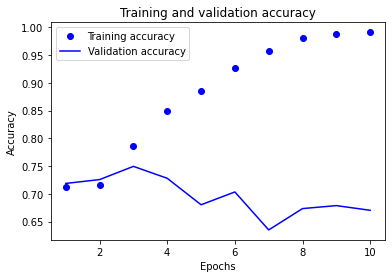

In [157]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1,11)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

### 5

In [168]:
embedding_dim = 20

In [172]:
model5 = Sequential()
model5.add(layers.Embedding(top_words, embedding_dim, input_length=mxlen))
model5.add(layers.Bidirectional(layers.GRU(256, return_sequences=True)))
model5.add(layers.GlobalAveragePooling1D())
model5.add(layers.Dense(64, activation='relu'))
model5.add(layers.Dropout(0.5))
model5.add(layers.Dense(3, activation='softmax'))
    
model5.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

In [173]:
checkpoint5 = ModelCheckpoint("best_model5.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model5.fit(X_train, y_train, epochs=10,validation_data=(X_test, y_test))

Epoch 1/10
131/131 [==============================] - 80s 574ms/step - loss: 0.8778 - accuracy: 0.7003 - val_loss: 0.7807 - val_accuracy: 0.7187
Epoch 2/10
131/131 [==============================] - 77s 591ms/step - loss: 0.7634 - accuracy: 0.7233 - val_loss: 0.7250 - val_accuracy: 0.7187
Epoch 3/10
131/131 [==============================] - 76s 580ms/step - loss: 0.5300 - accuracy: 0.7659 - val_loss: 0.7769 - val_accuracy: 0.6910
Epoch 4/10
118/131 [==========================>...] - ETA: 7s - loss: 0.3762 - accuracy: 0.8354

KeyboardInterrupt: 

In [159]:
from keras.utils import plot_model

In [162]:
plot_model(model4)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [ ]:
score = model5.evaluate(X_val, y_val)
print("Test Loss: %.2f%%" % (score[0]*100))
print("Test Accuracy: %.2f%%" % (score[1]*100))

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1,31)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

### Second was best

In [179]:
embedding_matrix = []

In [186]:
model6 = Sequential()
model6.add(layers.Embedding(top_words, 120, input_length=mxlen))
model6.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model6.add(layers.Dense(64,activation='softmax'))
model6.add(layers.Dropout(0.6))
model6.add(layers.Dense(16,activation='softmax'))
model6.add(layers.Dropout(0.5))
model6.add(layers.Dense(3,activation='softmax'))
model6.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint6 = ModelCheckpoint("best_model6.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model6.fit(X_train, y_train, epochs=30,validation_data=(X_test, y_test),callbacks=[checkpoint6])

Epoch 1/30
131/131 [==============================] - 158s 1s/step - loss: 1.0588 - accuracy: 0.4917 - val_loss: 0.9236 - val_accuracy: 0.7187

Epoch 00001: val_accuracy improved from -inf to 0.71868, saving model to best_model6.hdf5
Epoch 2/30
131/131 [==============================] - 148s 1s/step - loss: 0.9095 - accuracy: 0.7059 - val_loss: 0.8339 - val_accuracy: 0.7187

Epoch 00002: val_accuracy did not improve from 0.71868
Epoch 3/30
131/131 [==============================] - 150s 1s/step - loss: 0.8231 - accuracy: 0.7271 - val_loss: 0.8002 - val_accuracy: 0.7187

Epoch 00003: val_accuracy did not improve from 0.71868
Epoch 4/30
131/131 [==============================] - 152s 1s/step - loss: 0.7910 - accuracy: 0.7282 - val_loss: 0.7914 - val_accuracy: 0.7187

Epoch 00004: val_accuracy did not improve from 0.71868
Epoch 5/30
131/131 [==============================] - 149s 1s/step - loss: 0.8145 - accuracy: 0.7070 - val_loss: 0.7897 - val_accuracy: 0.7187

Epoch 00005: val_accuracy

In [187]:
score = model6.evaluate(X_val, y_val)
print("Test Loss: %.2f%%" % (score[0]*100))
print("Test Accuracy: %.2f%%" % (score[1]*100))

33/33 [==============================] - 0s 7ms/step - loss: 0.7842 - accuracy: 0.6657
Test Loss: 78.42%
Test Accuracy: 66.57%


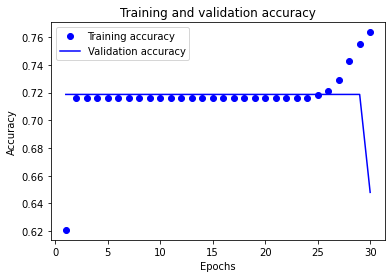

In [188]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1,31)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

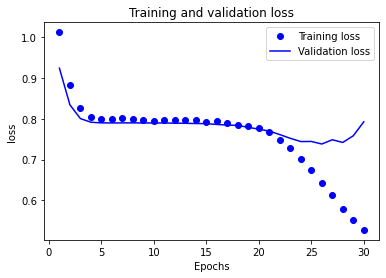

In [190]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,31)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

In [27]:
model7 = Sequential()
model7.add(layers.Embedding(top_words, 40, input_length=mxlen))
model7.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model7.add(layers.Dense(32,activation='softmax'))
model7.add(layers.Dropout(0.5))
model7.add(layers.Dense(16,activation='softmax'))
model7.add(layers.Dropout(0.5))
model7.add(layers.Dense(3,activation='softmax'))
model7.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint7 = ModelCheckpoint("best_model7.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model7.fit(X_train, y_train, epochs=40,validation_data=(X_test, y_test),callbacks=[checkpoint7])

Epoch 1/40
131/131 [==============================] - 34289s 264s/step - loss: 1.0585 - accuracy: 0.4889 - val_loss: 0.9159 - val_accuracy: 0.7187

Epoch 00001: val_accuracy improved from -inf to 0.71868, saving model to best_model7.hdf5
Epoch 2/40
131/131 [==============================] - 65s 494ms/step - loss: 0.9013 - accuracy: 0.7130 - val_loss: 0.8288 - val_accuracy: 0.7187

Epoch 00002: val_accuracy did not improve from 0.71868
Epoch 3/40
131/131 [==============================] - 56s 425ms/step - loss: 0.8251 - accuracy: 0.7187 - val_loss: 0.7981 - val_accuracy: 0.7187

Epoch 00003: val_accuracy did not improve from 0.71868
Epoch 4/40
131/131 [==============================] - 60s 461ms/step - loss: 0.8181 - accuracy: 0.7097 - val_loss: 0.7915 - val_accuracy: 0.7187

Epoch 00004: val_accuracy did not improve from 0.71868
Epoch 5/40
131/131 [==============================] - 64s 490ms/step - loss: 0.8070 - accuracy: 0.7163 - val_loss: 0.7904 - val_accuracy: 0.7187

Epoch 00005: 

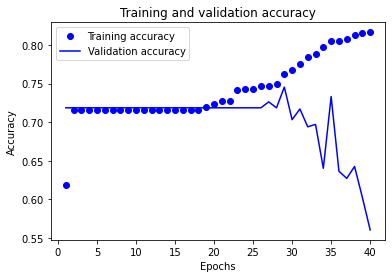

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1,41)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

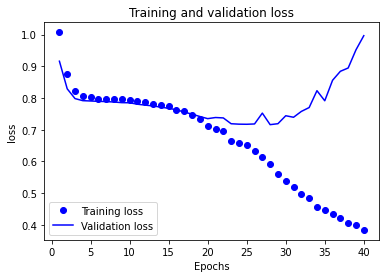

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,41)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

In [31]:
model8 = Sequential()
model8.add(layers.Embedding(top_words, 30, input_length=mxlen))
model8.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model8.add(layers.Dense(32,activation='softmax'))
model8.add(layers.Dropout(0.6))
model8.add(layers.Dense(3,activation='softmax'))
model8.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint8 = ModelCheckpoint("best_model7.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model8.fit(X_train, y_train, epochs=40,validation_data=(X_test, y_test),callbacks=[checkpoint8])

Epoch 1/40
131/131 [==============================] - 46s 325ms/step - loss: 0.9957 - accuracy: 0.6329 - val_loss: 0.8636 - val_accuracy: 0.7187

Epoch 00001: val_accuracy improved from -inf to 0.71868, saving model to best_model7.hdf5
Epoch 2/40
131/131 [==============================] - 40s 306ms/step - loss: 0.8655 - accuracy: 0.7169 - val_loss: 0.8123 - val_accuracy: 0.7187

Epoch 00002: val_accuracy did not improve from 0.71868
Epoch 3/40
131/131 [==============================] - 40s 308ms/step - loss: 0.8116 - accuracy: 0.7267 - val_loss: 0.7972 - val_accuracy: 0.7187

Epoch 00003: val_accuracy did not improve from 0.71868
Epoch 4/40
131/131 [==============================] - 40s 308ms/step - loss: 0.8153 - accuracy: 0.7144 - val_loss: 0.7924 - val_accuracy: 0.7187

Epoch 00004: val_accuracy did not improve from 0.71868
Epoch 5/40
131/131 [==============================] - 40s 308ms/step - loss: 0.7855 - accuracy: 0.7257 - val_loss: 0.7901 - val_accuracy: 0.7187

Epoch 00005: va

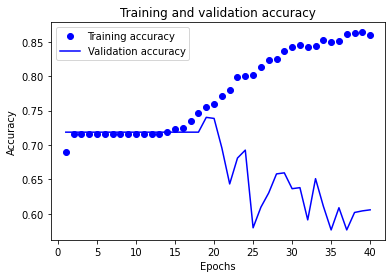

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1,41)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

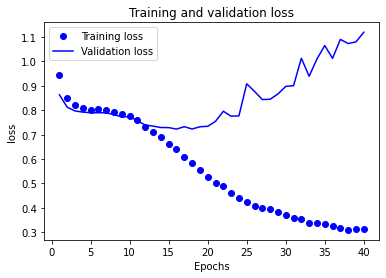

In [33]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,41)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

In [34]:
model9 = Sequential()
model9.add(layers.Embedding(top_words, 20, input_length=mxlen))
model9.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model9.add(layers.Dense(16,activation='softmax'))
model9.add(layers.Dropout(0.5))
model9.add(layers.Dense(3,activation='softmax'))
model9.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint9 = ModelCheckpoint("best_model7.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model9.fit(X_train, y_train, epochs=40,validation_data=(X_test, y_test),callbacks=[checkpoint9])

Epoch 1/40
131/131 [==============================] - 44s 270ms/step - loss: 0.9661 - accuracy: 0.6310 - val_loss: 0.8275 - val_accuracy: 0.7187

Epoch 00001: val_accuracy improved from -inf to 0.71868, saving model to best_model7.hdf5
Epoch 2/40
131/131 [==============================] - 30s 232ms/step - loss: 0.8403 - accuracy: 0.7203 - val_loss: 0.8055 - val_accuracy: 0.7187

Epoch 00002: val_accuracy did not improve from 0.71868
Epoch 3/40
131/131 [==============================] - 30s 231ms/step - loss: 0.8186 - accuracy: 0.7198 - val_loss: 0.7931 - val_accuracy: 0.7187

Epoch 00003: val_accuracy did not improve from 0.71868
Epoch 4/40
131/131 [==============================] - 31s 233ms/step - loss: 0.8104 - accuracy: 0.7150 - val_loss: 0.7888 - val_accuracy: 0.7187

Epoch 00004: val_accuracy did not improve from 0.71868
Epoch 5/40
131/131 [==============================] - 30s 227ms/step - loss: 0.8016 - accuracy: 0.7184 - val_loss: 0.7874 - val_accuracy: 0.7187

Epoch 00005: va

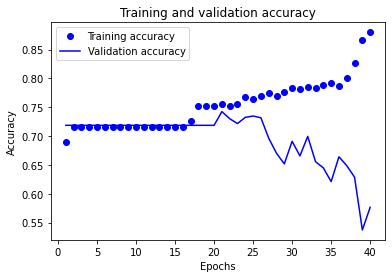

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1,41)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

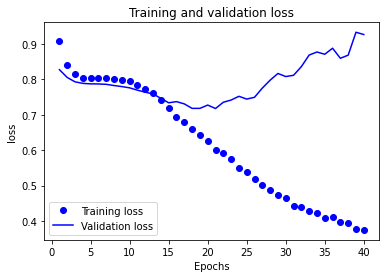

In [36]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,41)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

In [38]:
model10 = Sequential()
model10.add(layers.Embedding(top_words, 20)) #The embedding layer
model10.add(layers.LSTM(128,dropout=0.6)) #Our LSTM layer
model10.add(layers.Dense(32,activation='softmax'))
model10.add(layers.Dropout(0.5))
model10.add(layers.Dense(3,activation='softmax'))

model10.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint10 = ModelCheckpoint("best_model10.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model10.fit(X_train, y_train, epochs=30,validation_data=(X_test, y_test),callbacks=[checkpoint10])

Epoch 1/30
131/131 [==============================] - 37s 254ms/step - loss: 0.9434 - accuracy: 0.6673 - val_loss: 0.8389 - val_accuracy: 0.7187

Epoch 00001: val_accuracy improved from -inf to 0.71868, saving model to best_model10.hdf5
Epoch 2/30
131/131 [==============================] - 30s 230ms/step - loss: 0.8619 - accuracy: 0.7132 - val_loss: 0.8135 - val_accuracy: 0.7187

Epoch 00002: val_accuracy did not improve from 0.71868
Epoch 3/30
131/131 [==============================] - 30s 225ms/step - loss: 0.8283 - accuracy: 0.7159 - val_loss: 0.7953 - val_accuracy: 0.7187

Epoch 00003: val_accuracy did not improve from 0.71868
Epoch 4/30
131/131 [==============================] - 29s 224ms/step - loss: 0.8280 - accuracy: 0.7080 - val_loss: 0.7925 - val_accuracy: 0.7187

Epoch 00004: val_accuracy did not improve from 0.71868
Epoch 5/30
131/131 [==============================] - 29s 221ms/step - loss: 0.7879 - accuracy: 0.7275 - val_loss: 0.7908 - val_accuracy: 0.7187

Epoch 00005: v

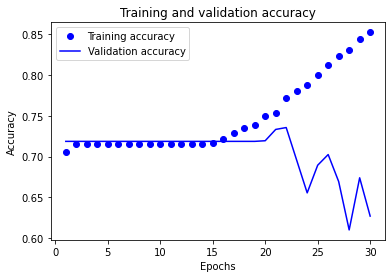

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1,31)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

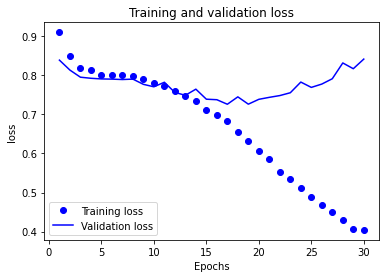

In [41]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,31)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

### Binary classification

In [10]:
data.sentiment = data.sentiment.replace(0,1)
data.head()

,text,sentiment
0,W 1992r szef PSL brał udział w obaleniu rzadu ...,1
1,Wladku pamiętamy twoja pomoc. Nam się to po n...,1
2,Panie Władeczku. To jakie były ustalenia ws. o...,-1
3,Ty zielona szmxxx!,-1
4,Nigdy nie ma zadowolenia w waszej partii sami ...,-1


In [15]:
(X_train, y_train, X_val, y_val, X_test, y_test) = data_splitter(data, top_words, mxlen, nb_classes)

Found 23160 unique tokens.
{'nie': 1, 'to': 2, 'i': 3, 'w': 4, 'na': 5, 'się': 6, 'z': 7, 'a': 8, 'jak': 9, 'do': 10, 'jest': 11, 'że': 12, 'pan': 13, 'co': 14, 'o': 15, 'za': 16, 'tak': 17, 'po': 18, 'ale': 19, 'czy': 20, 'tylko': 21, 'ty': 22, 'już': 23, 'bo': 24, 'dla': 25, 'od': 26, 'ma': 27, 'tym': 28, 'panie': 29, 'pis': 30, 'może': 31, 'tego': 32, 'ze': 33, 'będzie': 34, 'jeszcze': 35, 'pana': 36, 'też': 37, 'ten': 38, 'są': 39, 'tam': 40, 'jesteś': 41, 'by': 42, 'te': 43, 'gdzie': 44, 'nic': 45, 'teraz': 46, 'no': 47, 'ci': 48, 'sobie': 49, 'ja': 50, 'przez': 51, 'było': 52, 'być': 53, 'nawet': 54, 'kto': 55, 'trzeba': 56, 'wy': 57, 'polski': 58, 'coś': 59, 'sie': 60, 'dzieci': 61, 'pani': 62, 'żeby': 63, 'takie': 64, 'was': 65, 'lat': 66, 'chyba': 67, 'bez': 68, 'ich': 69, 'ludzi': 70, 'proszę': 71, 'kiedy': 72, 'można': 73, 'pod': 74, 'tej': 75, 'tych': 76, 'był': 77, 'mam': 78, 'u': 79, 'dlaczego': 80, 'przecież': 81, 'polaków': 82, 'mi': 83, 'bardzo': 84, 'ta': 85, 'masz': 

In [63]:
model1 = Sequential()
model1.add(layers.Embedding(top_words, 20)) #The embedding layer
model1.add(layers.LSTM(15,dropout=0.2)) #Our LSTM layer
model1.add(layers.Dense(1,activation='sigmoid'))

model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint1 = ModelCheckpoint("binary_est_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=30,validation_data=(X_test, y_test),callbacks=[checkpoint1])

Epoch 1/30
131/131 [==============================] - 31s 217ms/step - loss: 0.0000e+00 - accuracy: 0.7029 - val_loss: 0.0000e+00 - val_accuracy: 0.7187

Epoch 00001: val_accuracy improved from -inf to 0.71868, saving model to binary_est_model1.hdf5
Epoch 2/30
131/131 [==============================] - 27s 202ms/step - loss: 0.0000e+00 - accuracy: 0.7206 - val_loss: 0.0000e+00 - val_accuracy: 0.7187

Epoch 00002: val_accuracy did not improve from 0.71868
Epoch 3/30
131/131 [==============================] - 27s 205ms/step - loss: 0.0000e+00 - accuracy: 0.7195 - val_loss: 0.0000e+00 - val_accuracy: 0.7187

Epoch 00003: val_accuracy did not improve from 0.71868
Epoch 4/30
131/131 [==============================] - 27s 205ms/step - loss: 0.0000e+00 - accuracy: 0.7168 - val_loss: 0.0000e+00 - val_accuracy: 0.7187

Epoch 00004: val_accuracy did not improve from 0.71868
Epoch 5/30
131/131 [==============================] - 26s 201ms/step - loss: 0.0000e+00 - accuracy: 0.7363 - val_loss: 0.00

In [97]:
model1 = Sequential()
model1.add(layers.Embedding(top_words, 50)) #The embedding layer
model1.add(layers.LSTM(32)) #Our LSTM layer
model1.add(layers.Dense(64,activation='relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(32,activation='relu'))
model1.add(layers.Dense(1,activation='relu'))
model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint1 = ModelCheckpoint("binary_best_model1b.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=30,validation_data=(X_test, y_test),callbacks=[checkpoint1])

Epoch 1/30
131/131 [==============================] - 75s 550ms/step - loss: nan - accuracy: 0.7174 - val_loss: nan - val_accuracy: 0.7187

Epoch 00001: val_accuracy improved from -inf to 0.71868, saving model to binary_best_model1b.hdf5
Epoch 2/30
131/131 [==============================] - 70s 536ms/step - loss: nan - accuracy: 0.7106 - val_loss: nan - val_accuracy: 0.7187

Epoch 00002: val_accuracy did not improve from 0.71868
Epoch 3/30
131/131 [==============================] - 71s 542ms/step - loss: nan - accuracy: 0.7142 - val_loss: nan - val_accuracy: 0.7187

Epoch 00003: val_accuracy did not improve from 0.71868
Epoch 4/30
131/131 [==============================] - 71s 542ms/step - loss: nan - accuracy: 0.7060 - val_loss: nan - val_accuracy: 0.7187

Epoch 00004: val_accuracy did not improve from 0.71868
Epoch 5/30
131/131 [==============================] - 71s 543ms/step - loss: nan - accuracy: 0.7193 - val_loss: nan - val_accuracy: 0.7187

Epoch 00005: val_accuracy did not imp

KeyboardInterrupt: 

In [ ]:
score = model1.evaluate(X_val, y_val)
print("Test Loss: %.2f%%" % (score[0]*100))
print("Test Accuracy: %.2f%%" % (score[1]*100))

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1,31)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [89]:
model7b = Sequential()
model7b.add(layers.Embedding(top_words, 50, input_length=mxlen))
model7b.add(layers.LSTM(64))
model7b.add(layers.Dense(126,activation='relu'))
model7b.add(layers.Dropout(0.6))
model7b.add(layers.Dense(64,activation='relu'))
model7b.add(layers.Dropout(0.4))
model7b.add(layers.Dense(1,activation='sigmoid'))

model7b.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
checkpoint7b = ModelCheckpoint("binary_best_model7c.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model7b.fit(X_train, y_train, epochs=30,validation_data=(X_test, y_test),callbacks=[checkpoint7b])

Epoch 1/30
131/131 [==============================] - 186s 1s/step - loss: 0.6290 - accuracy: 0.6917 - val_loss: 0.5569 - val_accuracy: 0.7187

Epoch 00001: val_accuracy improved from -inf to 0.71868, saving model to binary_best_model7c.hdf5
Epoch 2/30
131/131 [==============================] - 177s 1s/step - loss: 0.4662 - accuracy: 0.7588 - val_loss: 0.5760 - val_accuracy: 0.7225

Epoch 00002: val_accuracy improved from 0.71868 to 0.72252, saving model to binary_best_model7c.hdf5
Epoch 3/30
131/131 [==============================] - 176s 1s/step - loss: 0.1303 - accuracy: 0.9597 - val_loss: 0.8259 - val_accuracy: 0.7264

Epoch 00003: val_accuracy improved from 0.72252 to 0.72636, saving model to binary_best_model7c.hdf5
Epoch 4/30
131/131 [==============================] - 190s 1s/step - loss: 0.0292 - accuracy: 0.9919 - val_loss: 1.1918 - val_accuracy: 0.7125

Epoch 00004: val_accuracy did not improve from 0.72636
Epoch 5/30
131/131 [==============================] - 200s 2s/step - 

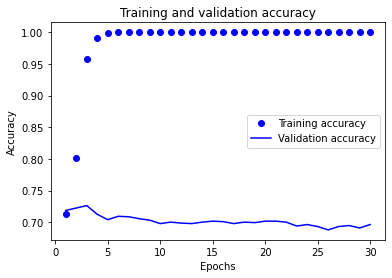

In [90]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1,31)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

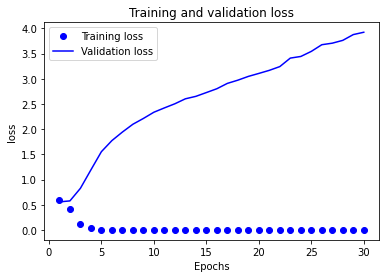

In [91]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,31)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

In [57]:
data['sentiment'] = data['sentiment'].replace(-1,0)

In [61]:
y_train

3056    0
5173    0
6499    0
5632    0
3318    0
       ..
5113    1
4429    0
1750    0
5583    0
1200    0
Name: sentiment, Length: 4162, dtype: int64

In [98]:
model7b.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 50, 50)            106156600 
_________________________________________________________________
lstm_22 (LSTM)               (None, 64)                29440     
_________________________________________________________________
dense_95 (Dense)             (None, 126)               8190      
_________________________________________________________________
dropout_62 (Dropout)         (None, 126)               0         
_________________________________________________________________
dense_96 (Dense)             (None, 64)                8128      
_________________________________________________________________
dropout_63 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_97 (Dense)             (None, 1)               

In [108]:
arr = model7b.predict(X_train)

In [109]:
arr

array([[9.6870124e-08],
       [6.5916855e-11],
       [4.1318575e-09],
       ...,
       [2.1041460e-19],
       [1.8927488e-09],
       [1.1216691e-09]], dtype=float32)

In [110]:
model7b

### Analyser

In [142]:
def text_reader(data, tweets, top_words, mxlen):
    X = data['text']

    X_tweets = tweets['text'
                     ]
    tokenizer = Tokenizer(num_words=top_words)
    tokenizer.fit_on_texts(X)
        
    sequences_text= tokenizer.texts_to_sequences(X_tweets)

    word_index = tokenizer.word_index
    #print('Found %s unique tokens.' % len(word_index))
    #print(word_index)

    X_tweets_return = sequence.pad_sequences(sequences_text, maxlen=mxlen)
    
    return(X_tweets_return)

In [119]:
holo = pd.read_csv('retweets/holownia_tweets.csv', index_col=0)

In [125]:
holo_ret = text_reader(data, holo, top_words, mxlen)

Found 23160 unique tokens.
{'nie': 1, 'to': 2, 'i': 3, 'w': 4, 'na': 5, 'się': 6, 'z': 7, 'a': 8, 'jak': 9, 'do': 10, 'jest': 11, 'że': 12, 'pan': 13, 'co': 14, 'o': 15, 'za': 16, 'tak': 17, 'po': 18, 'ale': 19, 'czy': 20, 'tylko': 21, 'ty': 22, 'już': 23, 'bo': 24, 'dla': 25, 'od': 26, 'ma': 27, 'tym': 28, 'panie': 29, 'pis': 30, 'może': 31, 'tego': 32, 'ze': 33, 'będzie': 34, 'jeszcze': 35, 'pana': 36, 'też': 37, 'ten': 38, 'są': 39, 'tam': 40, 'jesteś': 41, 'by': 42, 'te': 43, 'gdzie': 44, 'nic': 45, 'teraz': 46, 'no': 47, 'ci': 48, 'sobie': 49, 'ja': 50, 'przez': 51, 'było': 52, 'być': 53, 'nawet': 54, 'kto': 55, 'trzeba': 56, 'wy': 57, 'polski': 58, 'coś': 59, 'sie': 60, 'dzieci': 61, 'pani': 62, 'żeby': 63, 'takie': 64, 'was': 65, 'lat': 66, 'chyba': 67, 'bez': 68, 'ich': 69, 'ludzi': 70, 'proszę': 71, 'kiedy': 72, 'można': 73, 'pod': 74, 'tej': 75, 'tych': 76, 'był': 77, 'mam': 78, 'u': 79, 'dlaczego': 80, 'przecież': 81, 'polaków': 82, 'mi': 83, 'bardzo': 84, 'ta': 85, 'masz': 

In [127]:
model7b.predict(holo_ret)

array([[5.3716235e-06],
       [8.8763485e-10],
       [1.0000000e+00],
       [7.5534280e-07],
       [9.9999905e-01],
       [5.3716235e-06],
       [1.4086061e-06],
       [2.2746366e-01],
       [9.9621260e-01],
       [4.8166697e-07],
       [4.1481537e-01],
       [4.0232287e-10],
       [3.4021038e-01],
       [9.9999285e-01],
       [4.7157780e-13],
       [3.5938621e-04],
       [8.0751937e-07],
       [5.3716235e-06],
       [1.4324499e-08],
       [1.1383898e-17],
       [2.3313492e-11],
       [3.6753007e-09],
       [2.5438203e-06],
       [3.1909544e-23],
       [1.5791142e-10],
       [1.0000000e+00],
       [1.4540463e-10],
       [4.0540292e-12],
       [5.3716235e-06],
       [3.5938621e-04],
       [3.9686102e-19],
       [6.0529715e-06],
       [3.5938621e-04],
       [3.6753007e-09],
       [3.5528529e-01],
       [1.8976003e-01],
       [3.5938621e-04],
       [1.1757306e-08],
       [2.8843350e-10],
       [9.9999988e-01],
       [9.9999654e-01],
       [3.509908

In [134]:
holo['sent'] = model7b.predict(holo_ret)
holo['sent'] = round(holo['sent'],0)

<AxesSubplot:>

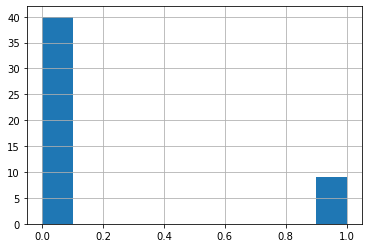

In [135]:
holo.sent.hist()

## 0 to negatywny

In [170]:
bosak = pd.read_csv('retweets/bosak_tweets.csv', index_col=0)
gill = pd.read_csv('retweets/gillpiatek_tweets.csv', index_col=0)
holownia = pd.read_csv('retweets/holownia_tweets.csv', index_col=0)
kosiniak = pd.read_csv('retweets/kosiniak_tweets.csv', index_col=0)
macierewicz = pd.read_csv('retweets/macierewicz_tweets.csv', index_col=0)
smiszek = pd.read_csv('retweets/smiszek_tweets.csv', index_col=0)
tusk = pd.read_csv('retweets/tusk_tweets.csv', index_col=0)
zandberg = pd.read_csv('retweets/zandberg_tweets.csv', index_col=0)
jachira = pd.read_csv('retweets/jachira_tweets.csv', index_col=0)
klimczak = pd.read_csv('retweets/klimaczak_tweets.csv', index_col=0)
sikorski = pd.read_csv('retweets/sikorski_tweets.csv', index_col=0)
trzaskowski = pd.read_csv('retweets/trzaskowski_tweets.csv', index_col=0)
biedron = pd.read_csv('retweets/biedron_tweets.csv', index_col=0)
braun = pd.read_csv('retweets/braun_tweets.csv', index_col=0)
budka = pd.read_csv('retweets/budka_tweets.csv', index_col=0)
duda = pd.read_csv('retweets/duda_tweets.csv', index_col=0)
lista_retweetow = [bosak,gill,holownia,kosiniak,macierewicz,smiszek,tusk,zandberg,jachira,klimczak,sikorski,trzaskowski,biedron,braun,budka,duda]
ktotojest = ['bosak','gillpiatel','holownia','kosiniak','macierewicz','smiszek','tusk','zandberg','jachira','klimczak','sikorski','trzaskowski','biedron','braun','budka','duda']

In [171]:
for i in range(0,16):
    print(ktotojest[i])
    final_sentiment = text_reader(data, lista_retweetow[i], top_words, mxlen)
    lista_retweetow[i]['sent'] = model7b.predict(final_sentiment)
    lista_retweetow[i]['sent'] = round(lista_retweetow[i]['sent'],0)

bosak
gillpiatel
holownia
kosiniak
macierewicz
smiszek
tusk
zandberg
jachira
klimczak
sikorski
trzaskowski
biedron
braun
budka
duda


In [172]:
for i in range(0,16):
    print(ktotojest[i])
    print('% negatywnych:',round(1 - lista_retweetow[i]['sent'].sum()/lista_retweetow[2]['sent'].count(),2))

bosak
% negatywnych: 0.51
gillpiatel
% negatywnych: 0.55
holownia
% negatywnych: 0.82
kosiniak
% negatywnych: 0.8
macierewicz
% negatywnych: 0.67
smiszek
% negatywnych: 0.65
tusk
% negatywnych: 0.8
zandberg
% negatywnych: 0.57
jachira
% negatywnych: 0.65
klimczak
% negatywnych: 0.84
sikorski
% negatywnych: 0.35
trzaskowski
% negatywnych: 0.53
biedron
% negatywnych: 0.67
braun
% negatywnych: 0.47
budka
% negatywnych: 0.88
duda
% negatywnych: 0.86


In [167]:
lista_retweetow[0]

,id,text,author,in_reply_to,sent
0,484140332,FB jak każdy przedsiębiorca ma prawo jednych ...,WooCash 🇵🇱🇪🇺,1478857196276535298,0.0
1,1476872790275993602,"Czyli zwyczajne przestrzeganie regulaminu, sz...",Bartek A,1478857196276535298,1.0
2,1220645337590915072,A gdyby tak użyć rozumu i nie czekać na propo...,Tessio,1478857196276535298,0.0
3,1286582335442489344,https://t.co/ePI0H2XLnn,Danon,1478857196276535298,0.0
4,963501864737234944,@WiktorSwietlik Trumpa powiesili to co dopier...,PrzemyslawXYZ🇵🇱,1478857196276535298,0.0
...,...,...,...,...,...
76,458050796,@KONFEDERACJA_ SUPER!!!🤣🤣🤣🤣🤣,Maciek Krasnicki,1478708297247211521,0.0
77,1273933188105228288,"@KONFEDERACJA_ Zwołujecie konferencję, żeby p...",Maja Taylor 🏳️‍🌈 🇪🇺 🇬🇧 🇵🇱,1478708297247211521,0.0
78,1046782948832350216,@KONFEDERACJA_ @Meta deregulacja. o co wam ch...,michal62583212,1478706642539659266,1.0
79,1477757083714043906,@Meta @sjkaleta Powiedz to TVNowi mądralo. Ka...,Rafał,1478696691834441731,0.0
